In [1]:
from matplotlib import rc

from pathlib import Path
import numpy as np
import os
import xarray as xr
# from dask.distributed import Client
import dask.array as da
from collections import OrderedDict               # We often use this to organise our experiments
import haversine
import matplotlib.pyplot as plt
# client = Client()
# client

## Figure out where to put our slice

In [3]:
%matplotlib inline

expt = "blank-ttide-20"
movietitle = "hourly_deepspeed-mixed.mp4"

# e = xr.open_mfdataset(f"/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output013/*hourly_e.nc",decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yh = slice(-52,-30))

v = xr.open_mfdataset(f"/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output013/*hourly_v.nc",decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yq = slice(-52,-30))
u = xr.open_mfdataset(f"/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output013/*hourly_u.nc",decode_times = False, parallel = True,chunks = "auto").sel(xq = slice(145,175),yh = slice(-52,-30))



speed = np.sqrt((v.interp({"yq":u.yh.values}).rename({"yq":"yh"})**2).v + (u.interp({"xq":v.xh.values}).rename({"xq":"xh"})**2).u).isel(time = 50).load()
# e = e.e.isel(time = 50).load()


fig,ax = plt.subplots(figsize = (10,10))
speed.plot(ax = ax,vmax = 0.2,cmap = cm.cm.speed)
ax.plot([148,165],[-41.0,-47.5],color = "red",linewidth = 1)
ax.plot([148,165],[-43.3,-49.8],color = "red",linewidth = 1)

KeyboardInterrupt: 

2023-10-13 15:47:55,396 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/profile.py", line 181, in process
    d = state["children"][ident]
KeyError: 'wrap;/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/dataclasses.py;1012'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
  

## Drafts of functions to be moved to postprocessing.py




In [2]:
# Calculate bearing between two lat long points
def bearing(lat1,lon1,lat2,lon2):
    """
    Calculates bearing between two lat long points

    Parameters
    ----------
    lat1 : float
        Latitude of first point
    lon1 : float
        Longitude of first point
    lat2 : float
        Latitude of second point
    lon2 : float
        Longitude of second point
    """
    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180
    lon1 = lon1 * np.pi / 180
    lon2 = lon2 * np.pi / 180
    y = np.sin(lon2-lon1) * np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1)
    return np.arctan2(y,x) * 180 / np.pi

# function for calculating distance between two lat long points



## User inputs here

In [51]:

path = Path("/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output013")
vector = np.array([[148,165],[-41.0,-47.5]])
bwdeg = 5 # width of beam in degrees


## Make our new grid
Need to get the corners of our domain in degrees, then construct our grid in kms. We'll round our domain to the nearest grid point in `xb` and `yb` which are the along beam and against beam coordinates

In [5]:
theta = bearing(vector[0,0],vector[0,1],vector[1,0],vector[1,1]) ## Angle to horizontal of our beam
blkm = haversine.haversine(vector[0,:],vector[1,:])              ## Length of our beam in km
bwkm1 = haversine.haversine((vector[0,0] - np.sin(theta) * 0.5 * bwdeg,vector[0,1] - np.cos(theta) * 0.5 * bwdeg),
                           (vector[0,0] + np.sin(theta) * 0.5 * bwdeg,vector[0,1] + np.cos(theta) * 0.5 * bwdeg)) ## Width of our beam in km
print(bwkm1)
print(blkm)

bwkm = haversine.haversine((vector[1,0] - np.sin(theta) * 0.5 * bwdeg,vector[1,1] - np.cos(theta) * 0.5 * bwdeg),
                           (vector[1,0] + np.sin(theta) * 0.5 * bwdeg,vector[1,1] + np.cos(theta) * 0.5 * bwdeg)) ## Width of our beam in km
print(bwkm / bwkm1)

428.2036949119608
1352.0582991923045
1.0643371421749617


## Callum's method

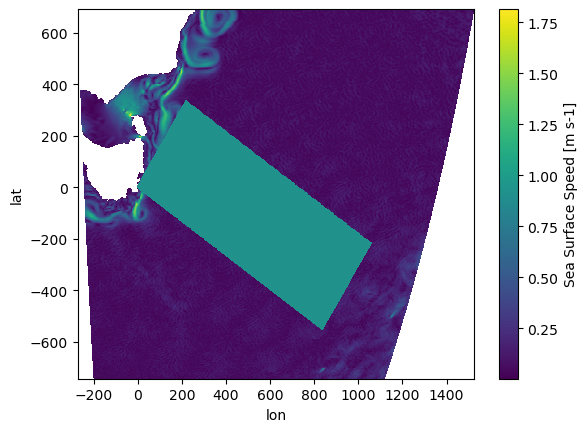

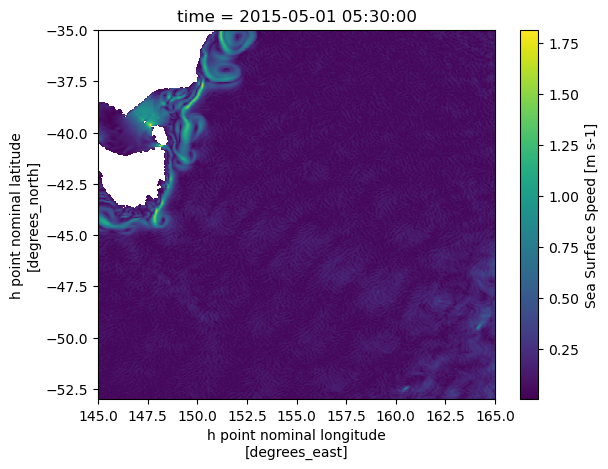

In [151]:
u = xr.open_dataset(path / "20150501.ocean_hourly.nc" ,chunks = "auto").speed.sel(xh = slice(145,165),yh = slice(-53,-35)).isel(time = 5).load()

lat0,lon0 = -41 * np.pi / 180,148 *np.pi / 180
lon = (u.xh.data) * np.pi / 180 - lon0
lat = u.yh.data * np.pi / 180

LAT , LON = np.meshgrid(lat,lon)

lat0,lon0 = -43 * np.pi / 180,148 *np.pi / 180

R = 6371
beamwidth_km = 400
beamlength_km = 1000

## Define the original grid on cartesian coordinates
x0,y0 = R * np.cos(lat0) * np.sin(lon0) , R * np.sin(lat0)
x0,y0 = 0 , R * np.sin(lat0)
x,y = R * np.cos(LAT) * np.sin(LON), R * np.sin(LAT) - y0

## Define target grid on rotated mesh in km
x_,y_ = np.linspace(0,beamlength_km,100),np.linspace(0,beamwidth_km,100)
X_,Y_ = np.meshgrid(x_,y_)
## Define the rotated grid as represented on the original grid. I.E, the points on x_ y_ as represented on the x,y coordinate system

theta_ = - theta

X , Y = X_ * np.cos(theta_) - Y_ * np.sin(theta_) , X_ * np.sin(theta_) + Y_ * np.cos(theta_)
u = u.assign_coords(
    {"lon":(["xh","yh"],x),
    "lat":(["xh","yh"],y)}
)
u.plot(x = "lon",y = "lat")

newgrid = xr.DataArray(
    data = X * 0,
    dims = ["i","j"],
    coords = {
        "lon":(["i","j"],X),
        "lat":(["i","j"],Y)

    }
)
newgrid.plot(x="lon",y = "lat",add_colorbar = False)

plt.figure()
u.plot()



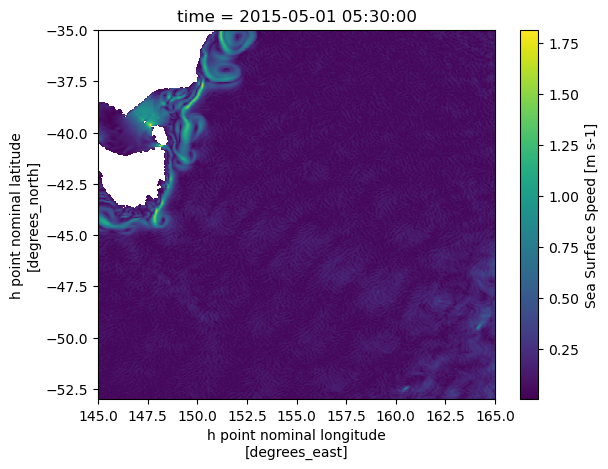

In [149]:
out = u.interp_like(newgrid)
out.plot()

In [146]:
regridder = xesmf.Regridder(
    u,newgrid,"bilinear"
)
out = regridder(u,keep_attrs = True)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


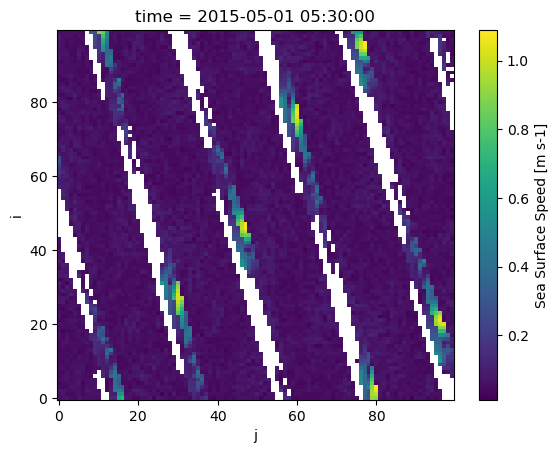

In [147]:
out.plot()

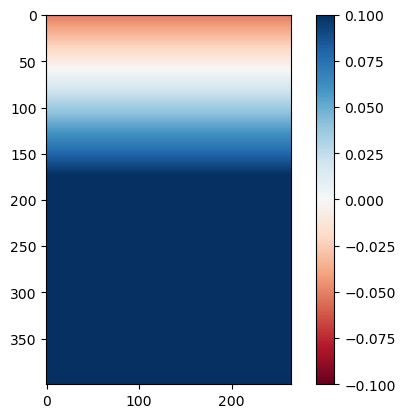

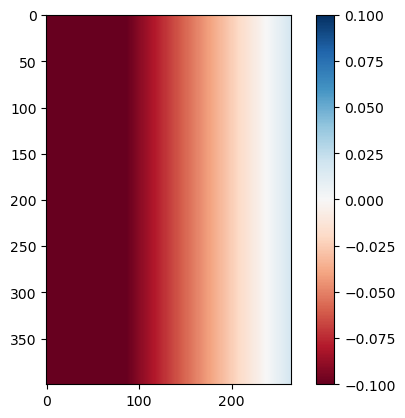

In [91]:


x0,y0 = R * np.cos(lat0) * np.sin(lon0) , R * np.sin(lat0)
x,y = R * np.cos(LAT) * np.sin(LON) -x0, R * np.sin(LAT) - y0

plt.imshow(LON - lon0,cmap = "RdBu",vmin = -0.1,vmax = 0.1)
plt.colorbar()
plt.figure()
plt.imshow(LAT - lat0,cmap = "RdBu",vmin = -0.1,vmax = 0.1)
plt.colorbar()

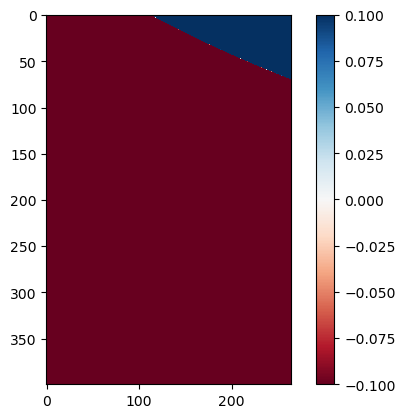

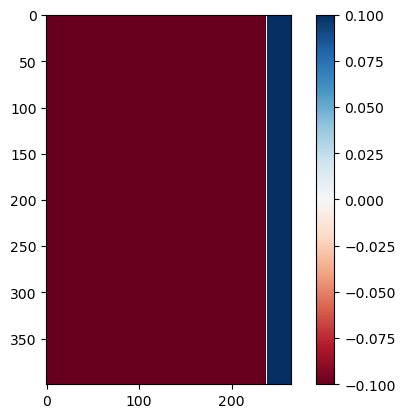

In [104]:
x0,y0 = R * np.cos(lat0) * np.sin(lon0) , R * np.sin(lat0)
x,y = R * np.cos(LAT) * np.sin(LON) -x0, R * np.sin(LAT) - y0

plt.imshow(x,cmap = "RdBu",vmin = -0.1,vmax = 0.1)
plt.colorbar()
plt.figure()
plt.imshow(y,cmap = "RdBu",vmin = -0.1,vmax = 0.1)
plt.colorbar()

## Interpolate base data onto cartesian

In [ ]:
ds_out = xr.dataarray(
    
)

u_cartesian = xesmf.Regridder(
    
)

## Test callum's method on some dummy data

In [11]:
os.listdir(path / "20150501.ocean_hourly.nc" )

NotADirectoryError: [Errno 20] Not a directory: '/g/data/nm03/ab8992/oldruns/blank-ttide-20/outputs/output013/20150501.ocean_hourly.nc'

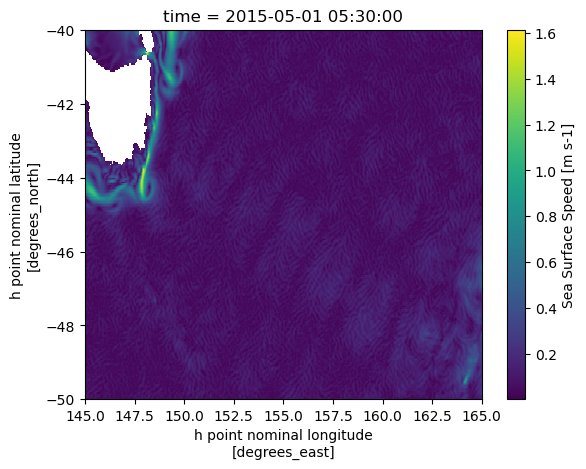

1097.0305524287555

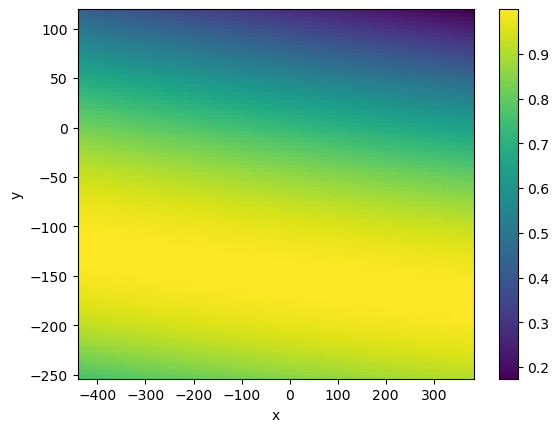

<Figure size 640x480 with 0 Axes>

In [29]:
LAT , LON = np.meshgrid(lat,lon)

T = xr.DataArray(
    data = np.sin(LAT**2 + LON**2),
    dims = {"lat":lat,"lon":lon},
    coords = {"x":(["lon"],x),
              "y":(["lat"],y)}
)

T.plot(x = "x",y = "y")
plt.figure()

x0